In [1]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import pickle
from collections import defaultdict
import re
from bs4 import BeautifulSoup
import sys
import os
os.environ['KERAS_BACKEND']='theano' # Why theano why not
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.layers import Embedding
from keras.layers import Dense, Input, Flatten
from keras.layers import Conv1D, MaxPooling1D, Embedding, Dropout
from keras.models import Model
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
plt.switch_backend('agg')
%matplotlib inline

In [2]:
#Upload the Dataset
from google.colab import files
uploaded = files.upload()

Saving reviews_clean.csv to reviews_clean.csv


In [3]:
# Dataset is now stored in a Pandas Dataframe
import io
data = pd.read_csv(io.BytesIO(uploaded['reviews_clean.csv']))

In [4]:
data.head()

,Unnamed: 0,Hotel_id,Hotel,Address,City,Title,Users,Reviews,Rating,Hotel_Type,Price,Hotel_Category,User_id,Sentiment,Label,Text_Clean,lemmatized,polarity
0,0,0,La Quinta,5820 Walden Rd,Beaumont,This hotel is a dump! Upon ch...,margierodriguez.mcqueen,This hotel is a dump! Upon checking in was tol...,1,2,Rs.8989,"Lodging,Motels,Hotels,Meeting & Event Planning...",15400,Negative,0,this hotel is a dump upon checking in was told...,hotel dump check tell place book folk run isaa...,0.188788
1,1,2,Inn At Queen Anne,505 1st Ave N,Seattle,Me and the little mouse,A Traveler2,Hope you are strong enough to carry all bags u...,2,2,Rs.8457,"hotel,Hotels",17618,Negative,0,hope you are strong enough to carry all bags u...,hope strong carry bag upstairs elevator coffee...,0.091667
2,2,2,Inn At Queen Anne,505 1st Ave N,Seattle,Unique hotel with character,A Traveler23,My boyfriend and I decided to stay at this hot...,4,2,Rs.8457,"hotel,Hotels",17602,Positive,1,my boyfriend and i decided to stay at this hot...,boyfriend decide stay hotel half price good ho...,0.258333
3,3,2,Inn At Queen Anne,505 1st Ave N,Seattle,Would stay again.,A Traveler22,The hotel was quaint and had a pleasant vibe t...,4,2,Rs.8457,"hotel,Hotels",17601,Positive,1,the hotel was quaint and had a pleasant vibe t...,hotel quaint pleasant vibe good size,0.716667
4,4,2,Inn At Queen Anne,505 1st Ave N,Seattle,Never Again!,A Traveler21,"Dirty, run down, poorly represented, nothing l...",1,2,Rs.8457,"hotel,Hotels",17600,Negative,0,dirty run down poorly represented nothing like...,dirty run poorly represent like picture descri...,-0.500000


In [5]:
# Checking for missing values
pd.isnull(data).any()

Unnamed: 0        False
Hotel_id          False
Hotel             False
Address           False
City              False
Title             False
Users             False
Reviews           False
Rating            False
Hotel_Type        False
Price             False
Hotel_Category    False
User_id           False
Sentiment         False
Label             False
Text_Clean         True
lemmatized         True
polarity          False
dtype: bool

In [6]:
data = data.dropna()
data = data.reset_index(drop=True)
print('Shape of dataset ',data.shape)
print(data.columns)
print('No. of unique classes',len(set(data['Sentiment'])))

Shape of dataset  (11998, 18)
Index(['Unnamed: 0', 'Hotel_id', 'Hotel', 'Address', 'City', 'Title', 'Users',
       'Reviews', 'Rating', 'Hotel_Type', 'Price', 'Hotel_Category', 'User_id',
       'Sentiment', 'Label', 'Text_Clean', 'lemmatized', 'polarity'],
      dtype='object')
No. of unique classes 2


In [7]:
def clean_str(string):
    string = re.sub(r"\\", "", string)
    string = re.sub(r"\'", "", string)
    string = re.sub(r"\"", "", string)
    return string

In [8]:
MAX_SEQUENCE_LENGTH = 1000
MAX_NB_WORDS = 20000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2

In [9]:
macronum=sorted(set(data['Label']))
macro_to_id = dict((note, number) for number, note in enumerate(macronum))

def fun(i):
    return macro_to_id[i]

data['Label']=data['Label'].apply(fun)

In [10]:
texts = []
labels = []


for idx in range(data.Text_Clean.shape[0]):
    text = BeautifulSoup(data.Text_Clean[idx])
    texts.append(clean_str(str(text.get_text().encode())))

for idx in data['Label']:
    labels.append(idx)

In [11]:

tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Number of Unique Tokens',len(word_index))

Number of Unique Tokens 26390


In [12]:
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

labels = to_categorical(np.asarray(labels))
print('Shape of Data Tensor:', data.shape)
print('Shape of Label Tensor:', labels.shape)

indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

x_train = data[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]
x_val = data[-nb_validation_samples:]
y_val = labels[-nb_validation_samples:]

Shape of Data Tensor: (11998, 1000)
Shape of Label Tensor: (11998, 2)


In [13]:
!wget http://nlp.stanford.edu/data/glove.6B.zip


--2020-10-10 09:38:48--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2020-10-10 09:38:48--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2020-10-10 09:38:49--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [14]:
!unzip glove*.zip


Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [15]:
!ls
!pwd

glove.6B.100d.txt  glove.6B.300d.txt  glove.6B.zip	 sample_data
glove.6B.200d.txt  glove.6B.50d.txt   reviews_clean.csv
/content


In [16]:
print('Indexing word vectors.')

embeddings_index = {}
f = open('glove.6B.100d.txt', encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Total %s word vectors in Glove 6B 100d..' % len(embeddings_index))

Indexing word vectors.
Total 400000 word vectors in Glove 6B 100d..


In [17]:
embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,trainable=True)

In [18]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
l_cov1= Conv1D(128, 5, activation='relu')(embedded_sequences)
l_pool1 = MaxPooling1D(5)(l_cov1)
l_cov2 = Conv1D(128, 5, activation='relu')(l_pool1)
l_pool2 = MaxPooling1D(5)(l_cov2)
l_cov3 = Conv1D(128, 5, activation='relu')(l_pool2)
l_pool3 = MaxPooling1D(35)(l_cov3)  # global max pooling
l_flat = Flatten()(l_pool3)
l_dense = Dense(128, activation='relu')(l_flat)
preds = Dense(len(macronum), activation='softmax')(l_dense)

model = Model(sequence_input, preds)
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

print("Simplified convolutional neural network")
model.summary()
cp=ModelCheckpoint('model_cnn.hdf5',monitor='val_acc',verbose=1,save_best_only=True)


Simplified convolutional neural network
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1000)]            0         
_________________________________________________________________
embedding (Embedding)        (None, 1000, 100)         2639100   
_________________________________________________________________
conv1d (Conv1D)              (None, 996, 128)          64128     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 199, 128)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 195, 128)          82048     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 39, 128)           0         
_________________________________________________________________
conv1d_2 (Conv

In [19]:
history=model.fit(x_train, y_train, validation_data=(x_val, y_val),epochs=7, batch_size=32,callbacks=[cp])


Epoch 1/7
300/300 [==============================] - ETA: 0s - loss: 0.4835 - acc: 0.7872
Epoch 00001: val_acc improved from -inf to 0.85035, saving model to model_cnn.hdf5
300/300 [==============================] - 95s 317ms/step - loss: 0.4835 - acc: 0.7872 - val_loss: 0.3561 - val_acc: 0.8504
Epoch 2/7
300/300 [==============================] - ETA: 0s - loss: 0.3529 - acc: 0.8536
Epoch 00002: val_acc improved from 0.85035 to 0.86286, saving model to model_cnn.hdf5
300/300 [==============================] - 95s 316ms/step - loss: 0.3529 - acc: 0.8536 - val_loss: 0.3168 - val_acc: 0.8629
Epoch 3/7
300/300 [==============================] - ETA: 0s - loss: 0.3002 - acc: 0.8805
Epoch 00003: val_acc improved from 0.86286 to 0.86328, saving model to model_cnn.hdf5
300/300 [==============================] - 98s 325ms/step - loss: 0.3002 - acc: 0.8805 - val_loss: 0.3181 - val_acc: 0.8633
Epoch 4/7
300/300 [==============================] - ETA: 0s - loss: 0.2519 - acc: 0.8997
Epoch 00004: 

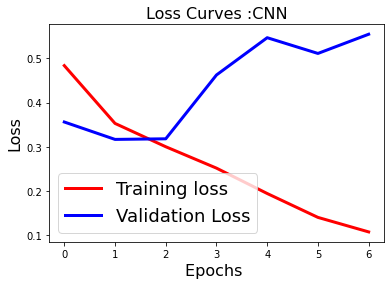

In [20]:
fig1 = plt.figure()
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves :CNN',fontsize=16)
fig1.savefig('loss_cnn.png')
plt.show()

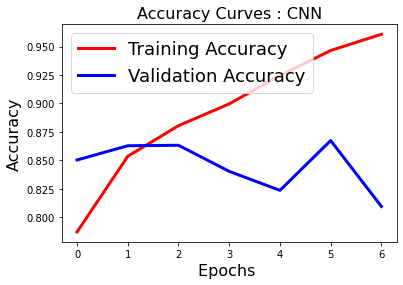

In [21]:
fig2=plt.figure()
plt.plot(history.history['acc'],'r',linewidth=3.0)
plt.plot(history.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves : CNN',fontsize=16)
fig2.savefig('accuracy_cnn.png')
plt.show()

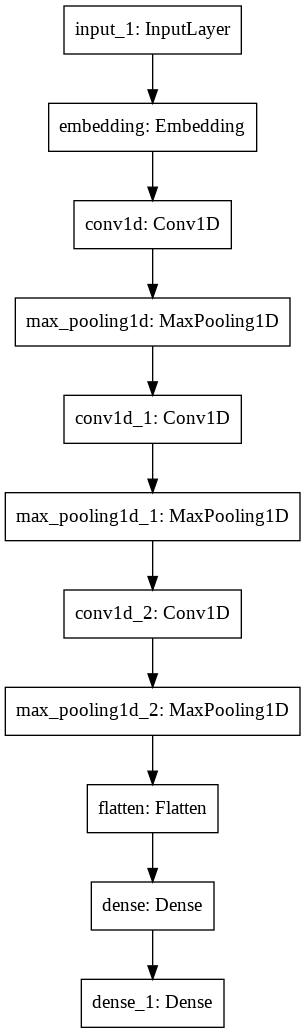

In [22]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='cnn_model.png')